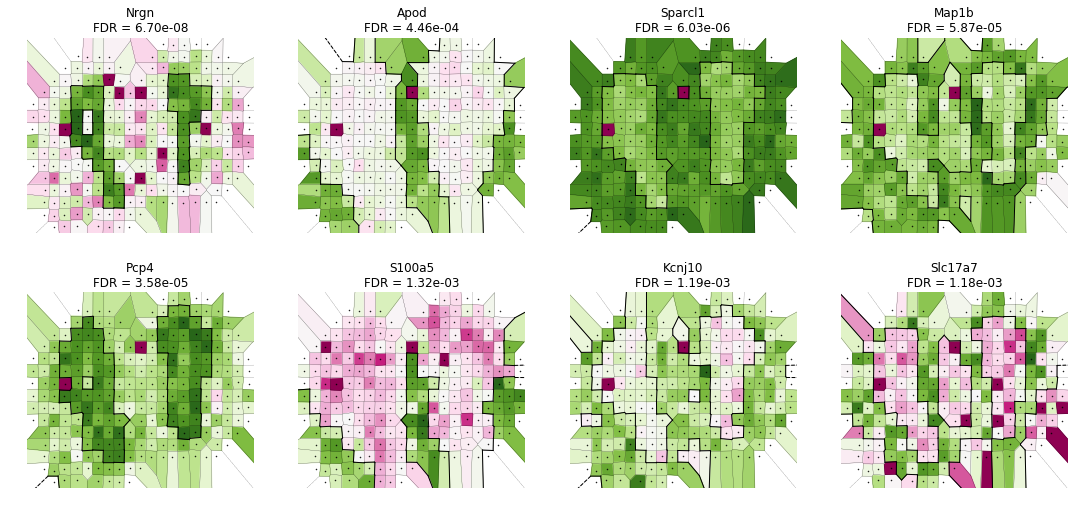

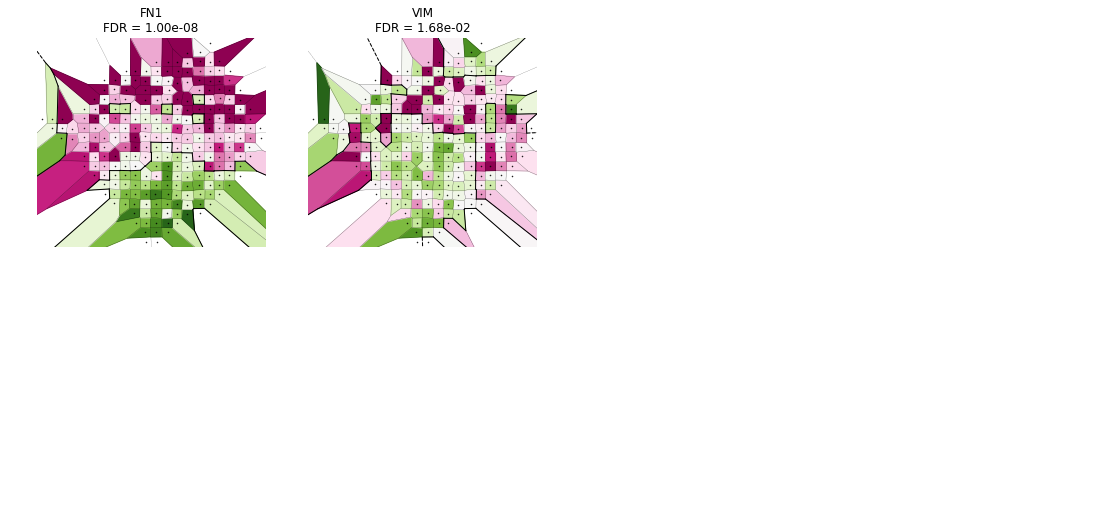

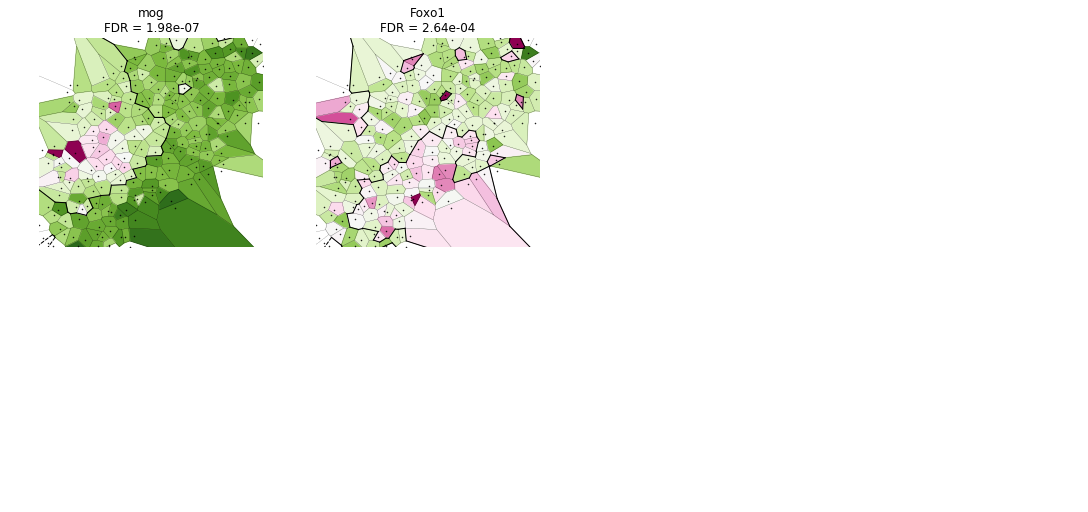

In [2]:
# generate figure 2C, 2E and 2F as shown in the manuscript
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import scGCO
import warnings
warnings.filterwarnings('ignore')

def visualize_spatial_genes(df, locs, data_norm,  
                    show_point = True, point_size = 1):
    '''
    plot spatial expression as voronoi tessellation to highlight boundary between classes
    format: 4 by 6
    :param file: df: graph cuts results; locs: spatial coordinates (n, 2); data_norm: normalized gene expression;
        point_size=0.5. 
    '''    
    points = locs
    geneID = df.index[0]
    exp =  data_norm.loc[:,geneID]
    exp=(scGCO.log1p(exp)).values
    cellGraph = scGCO.create_graph_with_weight(locs, exp)
    count = exp
    vor = Voronoi(points)
    nb_plots_per_page = 24
    nb_plots = int(df.shape[0])
    numCols = 4  # change back to 4 6
    numRows = 2
    t_numRows = int(df.shape[0]/numCols) + 1
    fsize = 7

    fig, axs = plt.subplots(numRows, numCols, figsize = (15, fsize), constrained_layout=True)
    for i in np.arange(df.shape[0]):                 
            geneID = df.index[i]
            exp =  data_norm.loc[:,geneID]
            exp=(scGCO.log1p(exp)).values
            if np.isnan(df.loc[geneID,].fdr):
                best_Labels = np.zeros(data_norm.shape[0])
            else:
                best_Labels = np.array((df.loc[geneID,]).astype(np.int32)[3:].values)
            m = int(i/numCols) % 6
            n = i % numCols 
            ax = axs[m,n]
            subplot_voronoi_boundary_new(geneID, locs, exp, best_Labels,
                                 df.loc[geneID,].fdr, ax=ax, fdr=True,
                                 point_size = point_size)

            if (i + 1) % nb_plots_per_page == 0 or (i + 1) == nb_plots:
                for ii in np.arange(numRows):
                    for jj in np.arange(numCols):        
                        axs[ii,jj].axis('off')

                        
#                pdf.savefig(fig)
              
    plt.show()
    fig.clear()
    plt.close()  

def subplot_voronoi_boundary_new(geneID, coord, count, 
                          classLabel, p, ax, fdr=False, show_point=False,
                          point_size = 1,  
                          line_colors = 'k', class_line_width = 1, 
                          line_width = 0.2, line_alpha = 1.0):
    '''
    plot spatial expression as voronoi tessellation
    highlight boundary between classes
    
    :param file: geneID; spatial coordinates (n, 2); count: shape (n,);predicted cell class calls (n); 
    '''
    points = coord
    locs = coord
    count = count
    labels = classLabel
    vor = Voronoi(points)

    minima = min(count)
    maxima = max(count)
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.PiYG)
    mapper.set_array(count)

    voronoi_plot_2d(vor, ax = ax, show_points=show_point, show_vertices=False, 
                    line_colors = line_colors, line_width = line_width, 
                    line_alpha = line_alpha, point_size = point_size)
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            ax.fill(*zip(*polygon), color=mapper.to_rgba(count[r]))
   
    # plot ridge between two points 
    center = points.mean(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
#        print(pointidx)
        # check whether the two points belong to different classes
        # and plot with color accoding to the classes
        if np.any(simplex < 0):
            if labels[pointidx[0]] != labels[pointidx[1]]:
                i = simplex[simplex >= 0][0] # finite end Voronoi vertex
                t = points[pointidx[1]] - points[pointidx[0]]  # tangent
                t = t / np.linalg.norm(t)
                n = np.array([-t[1], t[0]]) # normal
                midpoint = points[pointidx].mean(axis=0)
                far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
                ax.plot([vor.vertices[i,0], far_point[0]],
                    [vor.vertices[i,1], far_point[1]], 'k--', lw=class_line_width)
        else:
            if labels[pointidx[0]] != labels[pointidx[1]]:
                ax.plot(vor.vertices[simplex, 0], 
                        vor.vertices[simplex, 1], 'k-', lw=class_line_width)
                
    ax.scatter(locs[:,0], locs[:,1], marker='.',
               s=point_size, c='black', zorder=10)
    ax.set_xlim(min(points[:,0])-0.5, max(points[:,0]) + 0.5); 
    ax.set_ylim(min(points[:,1])-0.5, max(points[:,1]) + 0.5)
#    ax.colorbar(mapper)
    if fdr:
        titleText = geneID + '\n' + 'FDR = ' + str("{:.2e}".format(p))
    else:
        titleText = geneID + '  ' + 'P = ' + str("{:.2e}".format(p))    
    ax.set_title(titleText, fontname="Arial", fontsize=12)
#    ax.axis('off')

# plot Fig. 2C

gco = 'scGCO_results/MOB_Rep11.csv'
counts_gco = pd.read_csv(gco, index_col=0)
genes = ['Nrgn', 'Apod', 'Sparcl1', 'Map1b', 'Pcp4', 'S100a5', 'Kcnj10', 'Slc17a7']
df_sel = counts_gco.loc[genes,]
ff = 'Data/Rep11_MOB_count_matrix-1.tsv'
locs, data = scGCO.read_spatial_expression(ff)
# remove genes expressed in less than 10 cells
data = data.loc[:,(data != 0).astype(int).sum(axis=0) >= 10]
# normalize expression and use 1000 genes to test the algorithm
data_norm = scGCO.normalize_count_cellranger(data)
visualize_spatial_genes(df_sel, locs, data_norm)

# plot Fig. 2E

gco = 'scGCO_results/BC_Layer2.csv'
counts_gco = pd.read_csv(gco, index_col = 0)
genes = ['FN1', 'VIM']
df_sel = counts_gco.loc[genes,]
ff = 'Data/Layer2_BC_count_matrix-1.tsv'
locs, data = scGCO.read_spatial_expression(ff)
# remove genes expressed in less than 10 cells
data = data.loc[:,(data != 0).astype(int).sum(axis=0) >= 10]
# normalize expression and use 1000 genes to test the algorithm
data_norm = scGCO.normalize_count_cellranger(data)
visualize_spatial_genes(df_sel, locs, data_norm)

# plot Fig. 2F

gco = 'scGCO_results/mouse-hipo_field-43.csv'
counts_gco = pd.read_csv(gco, index_col = 0)
genes = ['mog', 'Foxo1']
df_sel = counts_gco.loc[genes,]
ff= 'Data/field_43_count_matrix-1.csv'
locs, data = scGCO.read_spatial_expression(ff)
# remove genes expressed in less than 10 cells
data = data.loc[:,(data != 0).astype(int).sum(axis=0) >= 10]
# normalize expression and use 1000 genes to test the algorithm
data_norm = scGCO.normalize_count_cellranger(data)
visualize_spatial_genes(df_sel, locs, data_norm)